# Higgs Twitter Dataset study 

Librairie utilisée

In [1]:
import gzip
import networkx as nx
import urllib.request
import matplotlib.pyplot as plt
import community

## Préparation et import des données du Higgs Twitter dataset à l'aide de la librairie Networkx

Code permettant de déziper les fichiers afin d'extraire les informations du dataset et de les mettre sous forme de graphe à l'aide de la librairie Networkx.

In [3]:
social_network_path = "higgs-social_network.edgelist.gz"
social_network = nx.read_edgelist(gzip.open(social_network_path), create_using=nx.DiGraph())

retweet_network_path = "higgs-retweet_network.edgelist.gz"
retweet_network = nx.read_weighted_edgelist(gzip.open(retweet_network_path), create_using=nx.DiGraph())

# reply_network_path = "higgs-reply_network.edgelist.gz"
# reply_network = nx.read_weighted_edgelist(gzip.open(reply_network_path), create_using=nx.DiGraph())

# mention_network_path = "higgs-mention_network.edgelist.gz"
# mention_network = nx.read_weighted_edgelist(gzip.open(mention_network_path), create_using=nx.DiGraph())

network_list = [social_network, retweet_network]

In [35]:
print(network_list)

[<networkx.classes.digraph.DiGraph object at 0x00000206DFE07D90>, <networkx.classes.digraph.DiGraph object at 0x0000020716D75A90>]


In [13]:
def display_stat(network_list):

    # Calculer les statistiques
    print("Nombre de nœuds et d'arêtes :")
    print("Social network : ", network_list[0].number_of_nodes(), network_list[0].number_of_edges())
    print("Retweet network : ", network_list[1].number_of_nodes(), network_list[1].number_of_edges())
    # print("Reply network : ", network_list[2].number_of_nodes(), network_list[2].number_of_edges())
    # print("Mention network : ", network_list[3].number_of_nodes(), network_list[3].number_of_edges())

In [37]:
def reduction_percentage(initial_value, new_value):
    reduction_percent = ((initial_value - new_value) / initial_value) * 100
    print("Diminution de ", reduction_percent, "%") 

In [38]:
display_stat(network_list)

Nombre de nœuds et d'arêtes :
Social network :  456626 14855842
Retweet network :  256491 328132


Il y a beaucoup beaucoup de noeuds et d'arêtes dans ces jeux de données. Afin de diminuer les temps de calculs et de rendre possible l'étude nous allons effectuer quelques étapes de pré-traitements.

1) Supprimer les nœuds isolés : les nœuds qui n'ont pas de liens avec d'autres nœuds n'apportent pas beaucoup d'informations et peuvent être supprimés.

In [4]:
def supp_isolated_nodes(network_list):
    for network in network_list:
        isolated_nodes = list(nx.isolates(network))
        network.remove_nodes_from(isolated_nodes)


In [5]:
supp_isolated_nodes(network_list)

In [41]:
display_stat(network_list)

Nombre de nœuds et d'arêtes :
Social network :  456626 14855842
Retweet network :  256491 328132


Il n'y a pas de noeuds isolés au sein des datasets. Nous allons nous intéresser à d'autres mesures pour supprimer les arêtes et les noeuds n'ayant pas de rôle important dans le réseau.

2) Supprimer les nœuds avec un degré faible : les nœuds qui ont un faible nombre de connexions avec d'autres nœuds peuvent être supprimés car ils ne jouent pas un rôle important dans le réseau.

Le choix du seuil dépend du contexte de l'analyse et des objectifs de l'étude. En général, on peut choisir un seuil qui permet de supprimer les noeuds qui ont un faible impact sur la connectivité globale du réseau, tout en conservant la structure et les motifs locaux du réseau.

In [6]:
def supp_low_degree(network_list, threshold=15):
    saved_network=[]
    for network in network_list:
        network_copie = network.copy()
        # Calculer le degré moyen des noeuds du réseau
        degree_connectivity = nx.average_degree_connectivity(network_copie)
        avg_degree = sum(k * v for k, v in degree_connectivity.items()) / len(network_copie)

        low_degree_nodes = [node for node, degree in network_copie.degree() if degree <= 0.7*avg_degree]
        network_copie.remove_nodes_from(low_degree_nodes)
        saved_network.append(network_copie)
    return saved_network


In [7]:
new_network = supp_low_degree(network_list)

In [44]:
display_stat(new_network)

Nombre de nœuds et d'arêtes :
Social network :  1854 71061
Retweet network :  32095 89556


3) Supprimer les arêtes avec un poids faible : les arêtes qui ont un faible poids peuvent être supprimées car elles ne contribuent pas beaucoup à la structure du réseau.

In [8]:
import numpy as np

def supp_low_edges(network_list):
    saved_network=[]
    for network in network_list:
        network_copie = network.copy()
        # Calculer la moyenne des poids des arêtes
        weights = nx.get_edge_attributes(network_copie, 'weight').values()
        avg_weight = np.mean(list(weights))

        low_weight_edges = [(u, v) for u, v, w in network_copie.edges(data='weight') if w is not None and w <= 0.7*avg_weight]

        network_copie.remove_edges_from(low_weight_edges)
        saved_network.append(network_copie)
    return saved_network


In [9]:
new_network = supp_low_edges(new_network)

c:\Users\coco8\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\coco8\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
display_stat(new_network)

Nombre de nœuds et d'arêtes :
Social network :  1854 71061
Retweet network :  32095 89556


4) Supprimer les nœuds et les arêtes en fonction de la centralité : les nœuds et les arêtes avec une faible centralité peuvent être supprimés car ils ne sont pas très importants pour la structure du réseau.

In [10]:
def supp_if_low_centrality(network_list):
    saved_network=[]
    for network in network_list:
        network_copie = network.copy()
        # Supprimer les nœuds avec une centralité de degré faible
        avg_centrality = sum(nx.degree_centrality(network_copie).values()) / len(network_copie)
        low_degree_centrality_nodes = [node for node, centrality in nx.degree_centrality(network_copie).items() if centrality <= 0.7*avg_centrality]
        network_copie.remove_nodes_from(low_degree_centrality_nodes)

        # Supprimer les arêtes avec une centralité intermédiaire

        ebc = nx.edge_betweenness_centrality(network_copie)
        mean_ebc = np.mean(list(ebc.values()))
        intermediate_betweenness_edges = [(u, v) for (u, v), centrality in ebc.items() if centrality <= 0.7*mean_ebc and centrality > 0]
        network_copie.remove_edges_from(intermediate_betweenness_edges)
        saved_network.append(network_copie)

    return saved_network

In [11]:
new_network = supp_if_low_centrality(new_network)

In [14]:
display_stat(new_network)

Nombre de nœuds et d'arêtes :
Social network :  990 18026
Retweet network :  12398 7244


In [51]:
# nx.draw(new_network[0], with_labels=False)
# plt.show()

In [52]:
# nx.draw(new_network[1], with_labels=False)
# plt.show()

Nous enregistrons les données afin de ne plus avoir dans la suite à refaire l'ensemble des pré-traitements.

In [53]:
for i, network in enumerate(new_network):
    # Enregistrer le réseau social modifié sous forme de fichier edgelist gzip
    new_social_network_path = "new" + str(network) + ".edgelist.gz"
    with gzip.open(new_social_network_path, 'wb') as f:
        nx.write_edgelist(network, f)

## Première étude : Extraction des communautés Twitter et détermination de leur niveau d'influence

Application de l'algorithme de Louvain : appliquez l'algorithme de Louvain à votre graphe pour identifier les communautés d'utilisateurs. L'algorithme de Louvain est un algorithme de clustering hiérarchique qui maximise la modularité du réseau. Vous pouvez utiliser une bibliothèque de clustering comme Louvain ou NetworkX pour appliquer l'algorithme de Louvain.

In [15]:

network_undirected = nx.Graph(new_network[0])

partition = community.best_partition(network_undirected)

num_communities = len(set(partition.values()))
print("Le réseau contient", num_communities, "communautés.")

for node, community_id in partition.items():
    print("Le nœud", node, "appartient à la communauté", community_id)


Le réseau contient 7 communautés.
Le nœud 2 appartient à la communauté 0
Le nœud 4 appartient à la communauté 0
Le nœud 5 appartient à la communauté 0
Le nœud 6 appartient à la communauté 0
Le nœud 7 appartient à la communauté 0
Le nœud 8 appartient à la communauté 0
Le nœud 10 appartient à la communauté 0
Le nœud 15 appartient à la communauté 0
Le nœud 19 appartient à la communauté 0
Le nœud 26 appartient à la communauté 0
Le nœud 27 appartient à la communauté 0
Le nœud 31 appartient à la communauté 0
Le nœud 32 appartient à la communauté 0
Le nœud 34 appartient à la communauté 0
Le nœud 39 appartient à la communauté 0
Le nœud 42 appartient à la communauté 1
Le nœud 43 appartient à la communauté 1
Le nœud 44 appartient à la communauté 0
Le nœud 48 appartient à la communauté 0
Le nœud 51 appartient à la communauté 0
Le nœud 52 appartient à la communauté 0
Le nœud 53 appartient à la communauté 0
Le nœud 55 appartient à la communauté 0
Le nœud 59 appartient à la communauté 0
Le nœud 63 a

Afin de pouvoir analyser ces communautés, nous allons effectuer différentes mesures au sein de ces communautés :

La taille de la communauté : nombre de nœuds appartenant à la communauté
La densité de la communauté : nombre de connexions présentes dans la communauté par rapport au nombre de connexions possibles
La centralité de la communauté : somme des centralités des nœuds appartenant à la communauté
La modularité de la communauté : mesure de la qualité de la partition des communautés, plus elle est proche de 1, meilleure est la partition

In [55]:
centrality = nx.betweenness_centrality(network_undirected)

# Initialiser un dictionnaire pour stocker les mesures pour chaque communauté
community_measures = {}

# Calculer les mesures pour chaque communauté
for node, community_id in partition.items():
    
    # Taille de la communauté
    if community_id in community_measures:
        community_measures[community_id]['size'] += 1
    else:
        community_measures[community_id] = {'size': 1}
    
    # Densité de la communauté
    node_neighbors = list(network_undirected.neighbors(node))
    num_internal_edges = sum(1 for neighbor in node_neighbors if partition[neighbor] == community_id)
    possible_internal_edges = len(node_neighbors) * (len(node_neighbors) - 1) / 2
    if possible_internal_edges > 0:
        internal_density = num_internal_edges / possible_internal_edges
    else:
        internal_density = 0
    if 'internal_density' in community_measures[community_id]:
        community_measures[community_id]['internal_density'] += internal_density
    else:
        community_measures[community_id]['internal_density'] = internal_density
    
    #Centralité de la communauté
    if 'centrality' in community_measures[community_id]:
        community_measures[community_id]['centrality'] += centrality[node]
    else:
        community_measures[community_id]['centrality'] = centrality[node]


# Calculer la modularité du réseau
modularity = community.modularity(partition, network_undirected)

import pandas as pd

# Créer une liste vide pour stocker les données de chaque communauté
data = []

# Itérer sur chaque communauté et extraire les mesures
for community_id, measures in community_measures.items():
    # Créer un dictionnaire avec les mesures
    community_data = {
        "Communauté": community_id,
        "Taille": measures["size"],
        "Densité interne": measures["internal_density"],
        "Centralité": measures["centrality"]
    }
    # Ajouter le dictionnaire à la liste
    data.append(community_data)

# Créer un dataframe à partir de la liste
df = pd.DataFrame(data)

# Afficher le dataframe
print(df)

print(f"Modularité : {modularity}")


   Communauté  Taille  Densité interne  Centralité
0           0     131         6.182675    0.149008
1           1     134         6.687164    0.141542
2           5     243        30.173101    0.393047
3           3     207        13.674066    0.354236
4           4     164         8.883961    0.313463
5           2      81         4.696541    0.052924
6           7       1         0.000000    0.000000
7           6      29         2.584047    0.023186
Modularité : 0.4078801024302009


La modularité est une mesure de la qualité de la division en communautés d'un réseau. Elle est comprise entre -1 et 1, où une valeur positive proche de 1 indique que la division en communautés est de haute qualité et une valeur négative proche de -1 indique que la division en communautés est de basse qualité.

Dans votre cas, la modularité est de 0.43, ce qui indique que la division en communautés est de relativement bonne qualité.

Ainsi, en regardant les données fournies, nous pouvons voir que la communauté 1 est la plus grande et a une densité interne élevée, ce qui peut indiquer une forte cohésion entre les nœuds de cette communauté. De plus, la centralité de la communauté 1 est également élevée, ce qui peut indiquer une grande influence de cette communauté dans l'ensemble du réseau.

D'un autre côté, la communauté 0 n'a qu'un seul nœud et une densité interne de 0, ce qui suggère qu'elle est isolée du reste du réseau. Il s'agit très certainement d'un outlier non détecté lors de l'étape de preprocessing.

Ainsi, cette analyse nous permet d'identifier les communautés les plus actives et les plus centrales dans le réseau social lié au Higgs boson. Si nous voulions mettre en place une stratégie de communication autour du boson de Higgs, nous pourrions alors cibler ces communautés en particulier. Nous pourrions également chercher à impliquer les membres de ces communautés dans votre campagne de communication en les incitant à partager votre contenu avec leur propre réseau social. En fin de compte, l'objectif serait de créer un effet boule de neige en utilisant l'influence des membres les plus centraux et les plus actifs des communautés les plus importantes pour atteindre un public plus large et influencer les discussions et les opinions sur le sujet du Higgs boson.

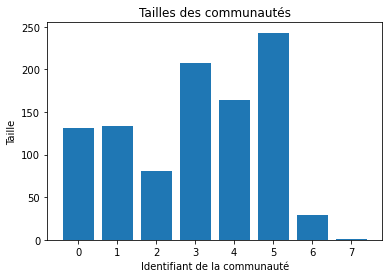

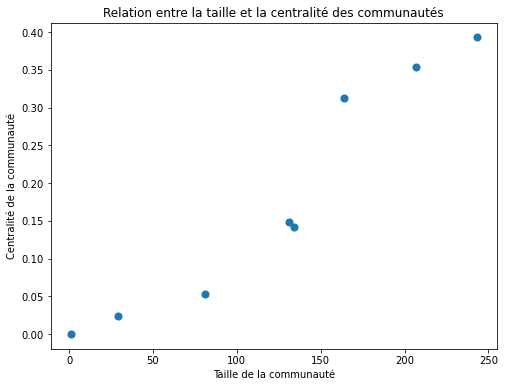

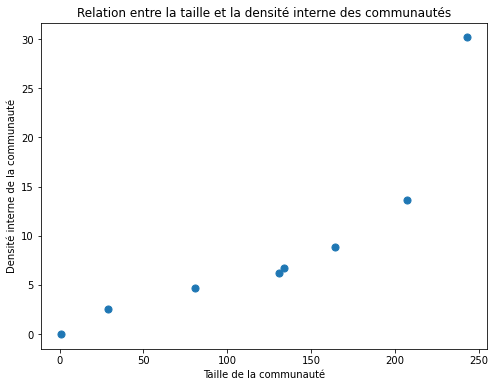

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Tracer un histogramme de la taille des communautés

# Récupération des tailles des communautés
community_sizes = [measures['size'] for measures in community_measures.values()]
community_ids = [community_id for community_id in community_measures.keys()]

# Tracé de l'histogramme
plt.bar(community_ids, community_sizes)
plt.title("Tailles des communautés")
plt.ylabel("Taille")
plt.xlabel("Identifiant de la communauté")
plt.show()



# Tracer un nuage de points de la centralité en fonction de la taille de la communauté
plt.figure(figsize=(8, 6))
plt.scatter(df['Taille'], df['Centralité'], s=50)
plt.xlabel('Taille de la communauté')
plt.ylabel('Centralité de la communauté')
plt.title('Relation entre la taille et la centralité des communautés')
plt.show()

# Tracer un nuage de points de la densité interne en fonction de la taille de la communauté
plt.figure(figsize=(8, 6))
plt.scatter(df['Taille'], df['Densité interne'], s=50)
plt.xlabel('Taille de la communauté')
plt.ylabel('Densité interne de la communauté')
plt.title('Relation entre la taille et la densité interne des communautés')
plt.show()


## Idées études suivantes :

### Extraction des personnes diffusant le plus l'information

Nous allons maintenant nous intéresser au dataset retweet afin de mettre en évidence les communautés et les personnes les plus à mêmes de diffuser une information. Ainsi, cela permettrait de cibler les personnes ayant un rôle important lors de la diffusion d'information. Voici le plan d'action à suivre :

Nous avons déjà au début chargé et prétraîté le dataset Retweet. Nous allons maintenant devoir générer une matrice d'adjacence normalisée à partir du graphe. En effet, cette matrice d'adjacence normalisée permet de transformer le graphe en une représentation matricielle, ce qui permet ensuite d'appliquer des techniques de traitement de données matricielles, telles que le graph embedding ou le k-means. De plus, la matrice d'adjacence normalisée permet de mettre en évidence les liens forts entre les nœuds, c'est-à-dire les groupes de nœuds qui ont tendance à être connectés les uns aux autres plus souvent qu'avec les autres nœuds du graphe.

Nous devons maintenant appliquer une technique de graph embedding pour projeter les noeuds du graphe dans un espace de dimension réduite.

Il existe plusieurs techniques de graph embedding, chacune ayant ses avantages et ses inconvénients en fonction du contexte et de la nature du graphe. Dans notre cas, étant donné que nous disposons d'un graphe non pondéré, la méthode de Laplacian eigenmaps peut être une option intéressante pour effectuer le graph embedding.

Cette méthode est basée sur la construction d'un laplacien normalisé, qui permet de projeter les nœuds du graphe dans un espace de dimensions inférieures tout en conservant leur structure. Cela permet de regrouper les nœuds similaires (par exemple, ceux appartenant à la même communauté) dans des régions de l'espace similaires.

In [16]:
# Génération de la matrice d'adjacence pondérée
adj_matrix = nx.adjacency_matrix(new_network[1], weight='weight').toarray()

# Calcul de la matrice D et D^-1
row_sum = np.sum(adj_matrix, axis=1)
D = np.diag(row_sum)
D += np.eye(D.shape[0]) * 1e-6  # régularisation de la matrice D
D_inv = np.linalg.inv(D)

# Calcul de la matrice d'adjacence normalisée
normalized_adj_matrix = D_inv @ adj_matrix

In [17]:
from sklearn.manifold import SpectralEmbedding

# projection dans un espace de dimensions inférieures
se = SpectralEmbedding(n_components=64, affinity='precomputed')
X = se.fit_transform(normalized_adj_matrix)

# sauvegarde des embeddings dans un fichier
np.savetxt("retweet_network_embeddings_1.csv", X, delimiter=",")


c:\Users\coco8\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\coco8\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Utiliser la méthode du coude pour déterminer le nombre optimal de clusters à utiliser dans l'algorithme de k-means.

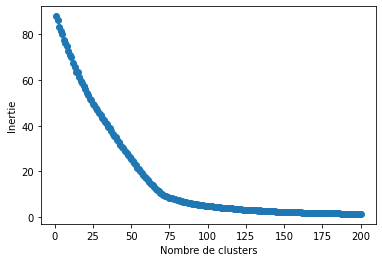

In [19]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Charger les embeddings à partir du fichier
X = np.loadtxt("retweet_network_embeddings_1.csv", delimiter=",")

# Initialiser la liste des valeurs d'inertie
inertias = []

# Définir le nombre maximal de clusters à tester
max_clusters = 200

# Calculer l'inertie pour chaque nombre de clusters k
for k in range(1, max_clusters+1):
    # Appliquer l'algorithme de k-means
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    
    # Ajouter l'inertie du modèle à la liste
    inertias.append(kmeans.inertia_)

# Tracer la courbe de l'inertie en fonction du nombre de clusters
plt.plot(range(1, max_clusters+1), inertias, '-o')
plt.xlabel('Nombre de clusters')
plt.ylabel("Inertie")
plt.show()


Nous observons le coude aux alentours de 60, nous appliquerons donc le K-means avec k=60

Appliquer l'algorithme de k-means pour diviser les noeuds du graphe en clusters, en utilisant le nombre optimal de clusters déterminé à l'étape 4.

In [20]:
# Définition de k
k = 60

# Application de l'algorithme de k-means
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

# Récupération des labels des clusters
labels = kmeans.labels_

# Affichage du nombre de noeuds dans chaque cluster
unique, counts = np.unique(labels, return_counts=True)
dico_cluster = dict(zip(unique, counts))
for k, v in dico_cluster.items():
    print("Cluster ",k+1, " has ", v, " nodes.")

Cluster  1  has  46  nodes.
Cluster  2  has  227  nodes.
Cluster  3  has  10605  nodes.
Cluster  4  has  6  nodes.
Cluster  5  has  2  nodes.
Cluster  6  has  2  nodes.
Cluster  7  has  2  nodes.
Cluster  8  has  2  nodes.
Cluster  9  has  3  nodes.
Cluster  10  has  20  nodes.
Cluster  11  has  7  nodes.
Cluster  12  has  2  nodes.
Cluster  13  has  25  nodes.
Cluster  14  has  2  nodes.
Cluster  15  has  2  nodes.
Cluster  16  has  2  nodes.
Cluster  17  has  30  nodes.
Cluster  18  has  2  nodes.
Cluster  19  has  2  nodes.
Cluster  20  has  3  nodes.
Cluster  21  has  8  nodes.
Cluster  22  has  2  nodes.
Cluster  23  has  4  nodes.
Cluster  24  has  19  nodes.
Cluster  25  has  21  nodes.
Cluster  26  has  59  nodes.
Cluster  27  has  44  nodes.
Cluster  28  has  3  nodes.
Cluster  29  has  32  nodes.
Cluster  30  has  25  nodes.
Cluster  31  has  33  nodes.
Cluster  32  has  6  nodes.
Cluster  33  has  33  nodes.
Cluster  34  has  35  nodes.
Cluster  35  has  30  nodes.
Cluster  

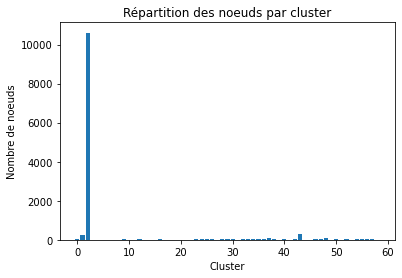

In [21]:
# Création de l'histogramme
plt.bar(range(k), [dico_cluster[i] for i in range(k)])
plt.xlabel('Cluster')
plt.ylabel('Nombre de noeuds')
plt.title('Répartition des noeuds par cluster')
plt.show()

### Etude de la diffusion d'influence 

In [61]:
centrality = nx.betweenness_centrality(network_undirected)

# Identifier la communauté la plus influente
most_influential_community_id = max(community_measures, key=lambda x: community_measures[x]['centrality'])

# Extraire le noeud le plus influent de la communauté la plus influente
most_influential_community = [(node, centrality[node]) for node, community_id in partition.items() if community_id == most_influential_community_id]
most_influential_node = max(most_influential_community, key=lambda x: x[1])[0]

# Identifier la communauté la moins influente
least_influential_community_id = min(community_measures, key=lambda x: community_measures[x]['centrality'])

# Extraire le noeud le moins influent de la communauté la moins influente
least_influential_community = [(node, centrality[node]) for node, community_id in partition.items() if community_id == least_influential_community_id]
least_influential_node = min(least_influential_community, key=lambda x: x[1])[0]

print("Le noeud le plus influent de la communauté la plus influente est :", most_influential_node)
print("Le noeud le moins influent de la communauté la moins influente est :", least_influential_node)



Le noeud le plus influent de la communauté la plus influente est : 16344
Le noeud le moins influent de la communauté la moins influente est : 396


In [62]:
import random

def simulate_icm(G, seed_node):
    # Initialisation
    t = 0
    active_nodes = {seed_node}
    new_active_nodes = {seed_node}
    size = 1
    
    # Simulation
    while new_active_nodes:
        t += 1
        curr_active_nodes = new_active_nodes
        new_active_nodes = set()
        for node in curr_active_nodes:
            neighbors = set(G.neighbors(node))
            for neighbor in neighbors:
                if neighbor in active_nodes:
                    continue
                # Probabilité d'activation
                p = random.uniform(0, 1)
                if p <= G[node][neighbor].get('weight', 1.0):
                    new_active_nodes.add(neighbor)
        active_nodes.update(new_active_nodes)
        size = len(active_nodes)
    
    # Calcul du taux de propagation
    n = len(G)
    propagation_rate = size / n
    
    return t, size, propagation_rate


In [63]:
simulate_icm(new_network[0], most_influential_node)

(5, 985, 0.9949494949494949)

In [64]:
simulate_icm(new_network[0], least_influential_node)

(1, 1, 0.00101010101010101)